# Notes

In this notebook we find optimal architecture for RNN network and compare its performance with shallow and deep CNN.

# Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

# Load the data

### Read the files

In [3]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [4]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### Augmented dataset

In [5]:
def sliding_window(X_arr, y_arr, time_window=100, time_step=1, time_stride=1):
    temp_x = np.moveaxis(X_arr, 2, 0)
    temp_x = temp_x.astype(np.float32)
    buff = []
    
    num_slices = (len(temp_x)-time_window*time_step) // time_stride + 1
    
    # get time slices for data
    for i in range(num_slices):
        buff.append(temp_x[i*time_stride:i*time_stride + time_window*time_step:time_step])
        buff[i] = np.moveaxis(buff[i], 0, 2)
        # uncomment this if additional dimension is needed
        # buff[i] = buff[i].reshape(1, buff[i].shape[0], buff[i].shape[1], buff[i].shape[2])
        
    temp_x = np.concatenate(buff)
        
    # get time slice for labels
    temp_y = np.ones((X_arr.shape[0],num_slices))
    
    for i in range(len(y_arr)):
        temp_y[i] = temp_y[i] * y_arr[i]
        
    temp_y = temp_y.reshape((-1))
    
    return temp_x, temp_y

# Experiment 1: Naive RNN model

In this experiment we calculate baseline accuracy for RNN model.

### Construct model

In [26]:
keras.backend.clear_session()

# input
naive_rnn_input = layers.Input(shape=(22, 1000))
# conv across channels?
p1 = layers.Permute((2, 1))(naive_rnn_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
f2 = layers.Flatten()(lstm2)
d2 = layers.Dense(64, activation="elu")(f2)

# output
naive_rnn_output = layers.Dense(4, activation="softmax")(d2)

### Compile model

In [27]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/naive_rnn_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


naive_rnn_model = keras.Model(inputs = naive_rnn_input, outputs = naive_rnn_output, name="naive_rnn_model")
naive_rnn_model.compile(optimizer="Adam", 
                        loss="sparse_categorical_crossentropy", 
                        metrics=["acc"])

In [28]:
naive_rnn_model.summary()

Model: "naive_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute (Permute)            (None, 1000, 22)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          22272     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4096064   
_________________________________________________________________
dense_1 (Dense)              (None, 4)             

### Train model

In [29]:
naive_rnn_model_loss_hist = naive_rnn_model.fit(X_train, y_train,
                                                validation_data = (X_valid, y_valid),
                                                epochs = 5,
                                                callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 2s - loss: 1.8725 - acc: 0.3035
Epoch 00001: val_loss improved from inf to 1.33201, saving model to ./model_checkpoints/naive_rnn_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/naive_rnn_1000\assets
1692/1692 [==============================] - 150s 89ms/sample - loss: 1.8645 - acc: 0.3026 - val_loss: 1.3320 - val_acc: 0.3452
Epoch 2/5
1664/1692 [============================>.] - ETA: 2s - loss: 1.0971 - acc: 0.5180
Epoch 00002: val_loss improved from 1.33201 to 1.26551, saving model to ./model_checkpoints/naive_rnn_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/naive_rnn_1000\assets
1692/1692 [==============================] - 184s 109ms/sample - loss: 1.0990 - acc: 0.5177 - val_loss: 1.2655 - val_acc: 0.4279
Epoch 3/5
1664/1692 [============================>.] - ETA: 3s - loss: 0.7006 - acc: 0.7560
Epoch 00003: val_loss did not improve from 1.26551
1692/

### Produce graphs

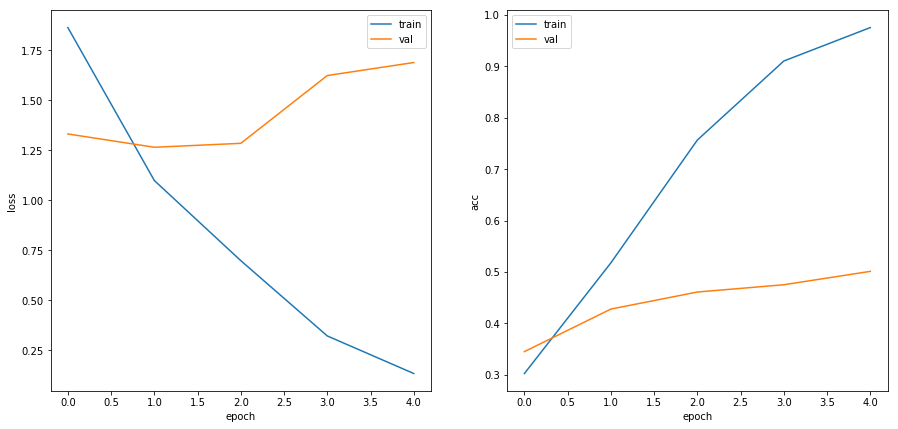

In [31]:
hist = naive_rnn_model_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 2: RNN with more layers.

In this experiment, we compare performance of baseline RNN and RNNs with more layers.

In [33]:
# input
rnn_3_lstm_1_dense_input = layers.Input(shape=(22, 1000))

# conv across channels?
p1 = layers.Permute((2, 1))(rnn_3_lstm_1_dense_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
lstm3 = layers.LSTM(64, return_sequences=True)(lstm2)
f2 = layers.Flatten()(lstm3)
d2 = layers.Dense(64, activation="elu")(f2)

# output
rnn_3_lstm_1_dense_output = layers.Dense(4, activation="softmax")(d2)

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_3_lstm_1_dense_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


rnn_3_lstm_1_dense_model = keras.Model(inputs = rnn_3_lstm_1_dense_input, outputs = rnn_3_lstm_1_dense_output)
rnn_3_lstm_1_dense_model.compile(optimizer="Adam", 
                                 loss="sparse_categorical_crossentropy", 
                                 metrics=["acc"])

rnn_3_lstm_1_dense_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute_2 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 64)          22272     
_________________________________________________________________
lstm_6 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4096

In [34]:
rnn_3_lstm_1_dense_model_loss_hist = rnn_3_lstm_1_dense_model.fit(X_train, y_train,
                                                                  validation_data = (X_valid, y_valid),
                                                                  epochs = 5,
                                                                  callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 3s - loss: 1.6527 - acc: 0.3311
Epoch 00001: val_loss improved from inf to 1.32762, saving model to ./model_checkpoints/rnn_3_lstm_1_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_1_dense_1000\assets
1692/1692 [==============================] - 211s 125ms/sample - loss: 1.6480 - acc: 0.3304 - val_loss: 1.3276 - val_acc: 0.3924
Epoch 2/5
1664/1692 [============================>.] - ETA: 4s - loss: 1.0913 - acc: 0.5541 
Epoch 00002: val_loss improved from 1.32762 to 1.28518, saving model to ./model_checkpoints/rnn_3_lstm_1_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_1_dense_1000\assets
1692/1692 [==============================] - 316s 187ms/sample - loss: 1.0891 - acc: 0.5556 - val_loss: 1.2852 - val_acc: 0.4515
Epoch 3/5
1664/1692 [============================>.] - ETA: 5s - loss: 0.7301 - acc: 0.7115 
Epoch 00003: val_

In [35]:
# input
rnn_3_lstm_2_dense_input = layers.Input(shape=(22, 1000))

# conv across channels?
p1 = layers.Permute((2, 1))(rnn_3_lstm_2_dense_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
lstm3 = layers.LSTM(64, return_sequences=True)(lstm2)
f2 = layers.Flatten()(lstm3)
d2 = layers.Dense(64, activation="elu")(f2)
d3 = layers.Dense(64, activation="elu")(d2)


# output
rnn_3_lstm_2_dense_output = layers.Dense(4, activation="softmax")(d3)

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_3_lstm_2_dense_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


rnn_3_lstm_2_dense_model = keras.Model(inputs = rnn_3_lstm_2_dense_input, outputs = rnn_3_lstm_2_dense_output)
rnn_3_lstm_2_dense_model.compile(optimizer="Adam", 
                                 loss="sparse_categorical_crossentropy", 
                                 metrics=["acc"])

rnn_3_lstm_2_dense_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute_3 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1000, 64)          22272     
_________________________________________________________________
lstm_9 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 1000, 64)          33024     
_________________________________________________________________
flatten_3 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4096

In [37]:
rnn_3_lstm_2_dense_model_loss_hist = rnn_3_lstm_2_dense_model.fit(X_train, y_train,
                                                                  validation_data = (X_valid, y_valid),
                                                                  epochs = 5,
                                                                  callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 5s - loss: 0.8260 - acc: 0.6845 
Epoch 00001: val_loss did not improve from 1.21840
1692/1692 [==============================] - 331s 196ms/sample - loss: 0.8264 - acc: 0.6850 - val_loss: 1.4114 - val_acc: 0.4374
Epoch 2/5
1664/1692 [============================>.] - ETA: 5s - loss: 0.4094 - acc: 0.8618 
Epoch 00002: val_loss did not improve from 1.21840
1692/1692 [==============================] - 331s 196ms/sample - loss: 0.4096 - acc: 0.8617 - val_loss: 1.6600 - val_acc: 0.4586
Epoch 3/5
1664/1692 [============================>.] - ETA: 5s - loss: 0.1963 - acc: 0.9339 
Epoch 00003: val_loss did not improve from 1.21840
1692/1692 [==============================] - 334s 198ms/sample - loss: 0.1977 - acc: 0.9332 - val_loss: 1.8766 - val_acc: 0.4823
Epoch 4/5
1664/1692 [============================>.] - ETA: 5s - loss: 0.0641 - acc: 0.9832 
Epoch 00004: val_loss did not improve fro

# Experiment 2 conclusion:

It can be argued, but based on the validation loss dynamics we can say that RNN does not significantly benefit from more layers.

# Experiment 3: augmentation of RNN architecture.

In this experiment, we show how RNN architecture is affected by architecture modifications, such as regularization,  number of hidden units, dropout. We start with dropout ~ 0.3 which is a common solution. Then we try different regularization, adter which variate number of hidden units and then dropout rate.

In [40]:
def construct_rnn_lstm_model(TIME_WINDOW=1000, hidden_units=64, dropout=0, regularizer=0):
    # input
    aug_rnn_input = layers.Input(shape=(22, TIME_WINDOW))

    p1 = layers.Permute((2, 1))(aug_rnn_input)
    lstm1 = layers.LSTM(hidden_units, 
                        return_sequences=True, 
                        dropout=dropout, 
                        kernel_regularizer=keras.regularizers.l2(regularizer))(p1)
    lstm2 = layers.LSTM(hidden_units, 
                        return_sequences=True, 
                        dropout=dropout,
                        kernel_regularizer=keras.regularizers.l2(regularizer))(lstm1)


    f2 = layers.Flatten()(lstm2)
    do2 = layers.Dropout(dropout)(f2)
    elu2 = layers.Dense(hidden_units, activation="elu",  kernel_regularizer=keras.regularizers.l2(regularizer))(do2)

    # output
    aug_rnn_output = layers.Dense(4, activation="softmax")(elu2)
    
    return keras.Model(inputs = aug_rnn_input, outputs = aug_rnn_output)

In [54]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.0001

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                  HIDDEN, 
                                                                                  DROPOUT, 
                                                                                  REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 4s - loss: 1.6933 - acc: 0.3438
Epoch 00001: val_loss improved from inf to 1.32933, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000\assets
1692/1692 [==============================] - 271s 160ms/sample - loss: 1.6847 - acc: 0.3452 - val_loss: 1.3293 - val_acc: 0.3972
Epoch 2/5
1664/1692 [============================>.] - ETA: 4s - loss: 0.9941 - acc: 0.6238
Epoch 00002: val_loss did not improve from 1.32933
1692/1692 [==============================] - 273s 161ms/sample - loss: 0.9964 - acc: 0.6235 - val_loss: 1.4541 - val_acc: 0.4255
Epoch 3/5
1408/1692 [=======================>......] - ETA: 42s - loss: 0.7389 - acc: 0.7267WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [ ]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.001

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                 HIDDEN, 
                                                                                 DROPOUT, 
                                                                                 REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

In [ ]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.005

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                 HIDDEN, 
                                                                                 DROPOUT, 
                                                                                 REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

In [ ]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.01

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                HIDDEN, 
                                                                                DROPOUT, 
                                                                                REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000.fit(X_train, y_train,
                                                         validation_data = (X_valid, y_valid),
                                                         epochs = 5,
                                                         callbacks=checkpoint_callback)

# NEW EXPERIMENTS HERE

We have to iterate through regularization through range approximately [0.1 - 0.0001], dropout - 0.2-0.5, hidden units - 32 to 128, sampl

## Get accuracies

In [ ]:
best_shallow_model_300 = keras.models.load_model('./model_checkpoints/shallow_model_300')
best_shallow_model_500 = keras.models.load_model('./model_checkpoints/shallow_model_500')
best_shallow_model_600 = keras.models.load_model('./model_checkpoints/shallow_model_600')
best_shallow_model_700 = keras.models.load_model('./model_checkpoints/shallow_model_700')
best_shallow_model_800 = keras.models.load_model('./model_checkpoints/shallow_model_800')
best_shallow_model_900 = keras.models.load_model('./model_checkpoints/shallow_model_900')
best_shallow_model_1000 = keras.models.load_model('./model_checkpoints/shallow_model_1000')

accuracies.append(best_shallow_model_1000.evaluate(X_valid_slices, y_valid_slices)[1])


# Augmented RNN model

It is clear that naive RNN model suffers from overfit - training loss of the model continues to drop while validation loss saturates and accuracy does not go beyond 50%. This can be fixed in 3 ways - dataset augmentation, architecture improvements and regularization.

1. Architecture improvements: add dropouts to our layers; try GRU instead of LSTM;
2. Dataset augmentation: normilize inputs, decrease the length of the example and upsample using sliding window approach - that produces correlation between examples, but if traning/validation/test sets are separated beforehand, that should be fine.
3. Regularizations: 

Results:

1. Dropout layers do not help to improve accuracy. It stays around 45% anyway
2. Augmentation allowed to achieve validation accuracy of 55% and test accuracy of 50% if std not squared. Trained for 2 epoch. If std is squared, 2 epochs give 52% validation and 50% test. After this accuracy satruates. From this moment on all data is presumed to be normilized without square.
3. Usage of sliding window lead to dramatic decrease of accuracy. From this point on it is assumed that no sliding wndow is applied.
4. a) With length of 1000 we can achieve 56% validation 54% test over 5 epochs. After this learning saturates.
4. b) Decrease of the length to 800 allowed to achieve 58% validation 55% test over 5 epochs. After this learning saturates.
4. c) Decrease of the length to 750 allowed to achieve 59% validation 53% test over 3 epochs. After this learning saturates. 
4. d) Decrease of the length to 600 allowed to achieve 65% validation 57% test over 5 epochs. After this learning saturates. 
4. e) Overall, the gain from smaller window is also small +/- 3% at best. This is why from now we will rn experiments with 1000 but in the end also try 750%.

5. When network starts to overfit you can decrease learning rate to 1e-4 to get a couple of additional persents.
6. Form this point on we use size of 1000 samples per example if reverse is not specified.
7. a) Added regularization to hidden layer of 0.001. Validation 56% test 53%
7. b) Added regularization to hidden layer of 0.1.

# Results

In [245]:
aug_rnn_model_results = aug_rnn_model.evaluate(X_test_slices, y_test_slices)

print('RNN model test loss:', aug_rnn_model_results[0])
print('RNN model test acc:', aug_rnn_model_results[1])

443/443 [==============================] - 6s 13ms/sample - loss: 1.8969 - acc: 0.5350
Naive RNN model test loss: 1.8969259714165336
Naive RNN model test acc: 0.5349887
